In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities.plotting2 import LossPlotter

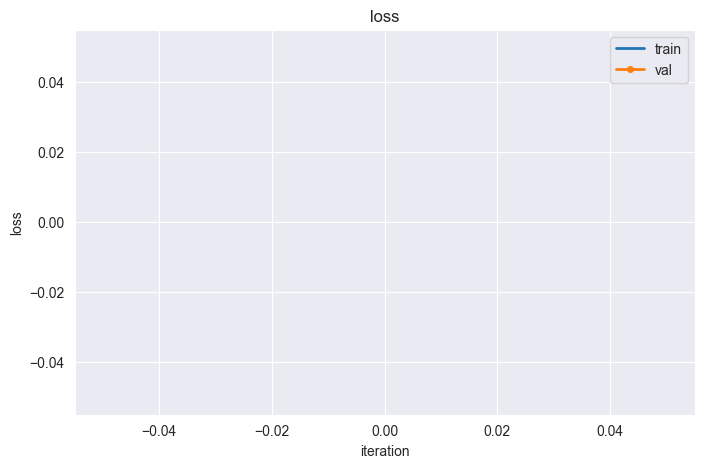

In [2]:
import time
import random
plotter = LossPlotter()

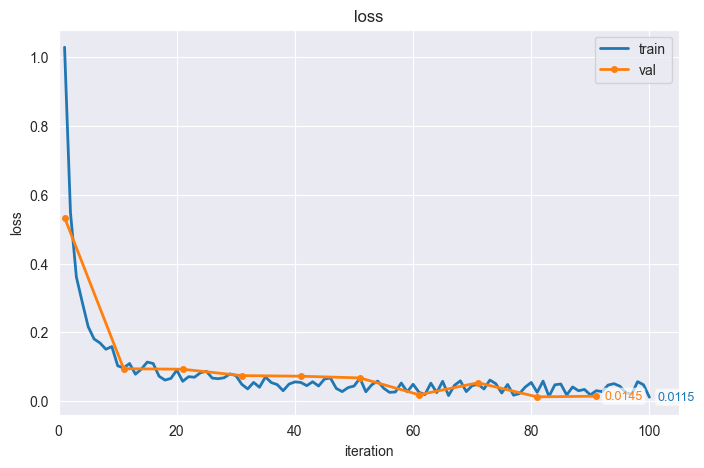

In [3]:
print("running")
for i in range(100):
  train_loss = 1 / (i + 1) + random.uniform(0, 0.05)
  val_loss = 1 / (i + 2) + random.uniform(0, 0.05) if i % 10 == 0 else None
  plotter.update(train_loss, val_loss)
  time.sleep(0.05)